In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from convOut_loader import convOut_Dataset

In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", show_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if show_cbar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
mode = 'residual'
convOut_path = '/data/HaoChen/knowledge_distillation/FeatureFactorization/convOut_CUB200_vgg16_bn_L37_.pkl'
resume = 'checkpoint_CUB200_Lu.pth.tar'
gpu = 0

In [4]:
if mode == 'residual':
    from linearTest_v2 import LinearTester
else:
    from linearTest import LinearTester

In [5]:
train_dataset = convOut_Dataset(convOut_path)
input_size = train_dataset.convOut1.shape[1:4]
output_size = train_dataset.convOut2.shape[1:4]
model = LinearTester(input_size,output_size, gpu_id= gpu).cuda(gpu)

In [6]:
checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(gpu)))
model.load_state_dict(checkpoint['state_dict'])
del checkpoint

In [7]:
i = 23
t = 19

In [20]:
pack = train_dataset[i]
input = pack['convOut1'].unsqueeze(0).cuda(gpu, non_blocking=True)
target = pack['convOut2']
output, output_n, output_contrib, res = model.val_linearity(input)
inputs = input.cpu().squeeze(0).numpy()
output = output.numpy()
output_n = output_n.numpy()
target = target.numpy()
residual = np.abs(target - output)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


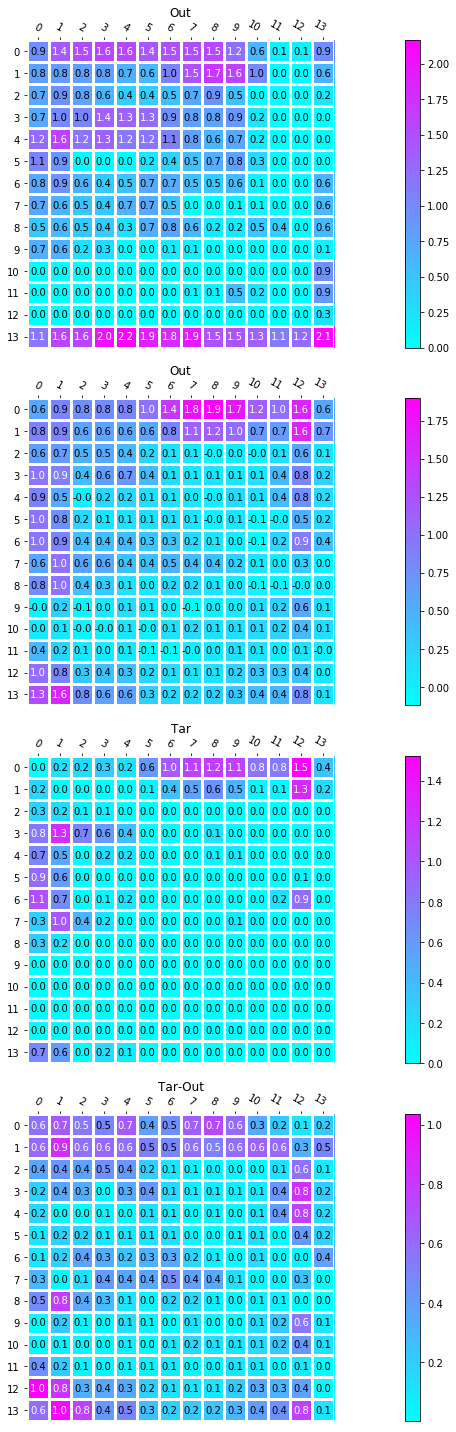

In [22]:
lab = range(14)
fig1, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(20,20))

im0, cbar0 = heatmap(inputs[t],lab,lab, ax=ax0,
                   cmap="cool", cbarlabel="")
texts1 = annotate_heatmap(im0, valfmt="{x:.1f}")
ax0.set_title('In', pad=24)

im1, cbar1 = heatmap(output[t],lab,lab, ax=ax1,
                   cmap="cool", cbarlabel="")
texts1 = annotate_heatmap(im1, valfmt="{x:.1f}")
ax1.set_title('Out', pad=24)

im2, cbar2 = heatmap(target[t],lab,lab, ax=ax2,
                   cmap="cool", cbarlabel="")
texts2 = annotate_heatmap(im2, valfmt="{x:.1f}")
ax2.set_title('Tar', pad=24)

# fig2, ax3 = plt.subplots(1,1,figsize=(5,5))
im3, cbar3 = heatmap(residual[t],lab,lab, ax=ax3,
                   cmap="cool", cbarlabel="")
texts3 = annotate_heatmap(im3, valfmt="{x:.1f}")
ax3.set_title('Tar-Out',pad=24)


fig1.tight_layout()
plt.show()

In [ ]:
t_list = [3,7,10,34,167,432,500]
for t in t_list:
    lab = range(14)
    fig1, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,20))
    
    im0, cbar0 = heatmap(inputs[t],lab,lab, ax=ax0,
                       cmap="cool", cbarlabel="",show_cbar=False)
    texts1 = annotate_heatmap(im0, valfmt="{x:.1f}")
    ax0.set_title('In', pad=24)
    
    im1, cbar1 = heatmap(output[t],lab,lab, ax=ax1,
                       cmap="cool", cbarlabel="", show_cbar=False)
    texts1 = annotate_heatmap(im1, valfmt="{x:.1f}")
    ax1.set_title('Out', pad=24)

    im2, cbar2 = heatmap(target[t],lab,lab, ax=ax2,
                       cmap="cool", cbarlabel="", show_cbar=False)
    texts2 = annotate_heatmap(im2, valfmt="{x:.1f}")
    ax2.set_title('Tar', pad=24)

    # fig2, ax3 = plt.subplots(1,1,figsize=(5,5))
    im3, cbar3 = heatmap(residual[t],lab,lab, ax=ax3,
                       cmap="cool", cbarlabel="", show_cbar=False)
    texts3 = annotate_heatmap(im3, valfmt="{x:.1f}")
    ax3.set_title('|Tar-Out|',pad=24)


    fig1.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


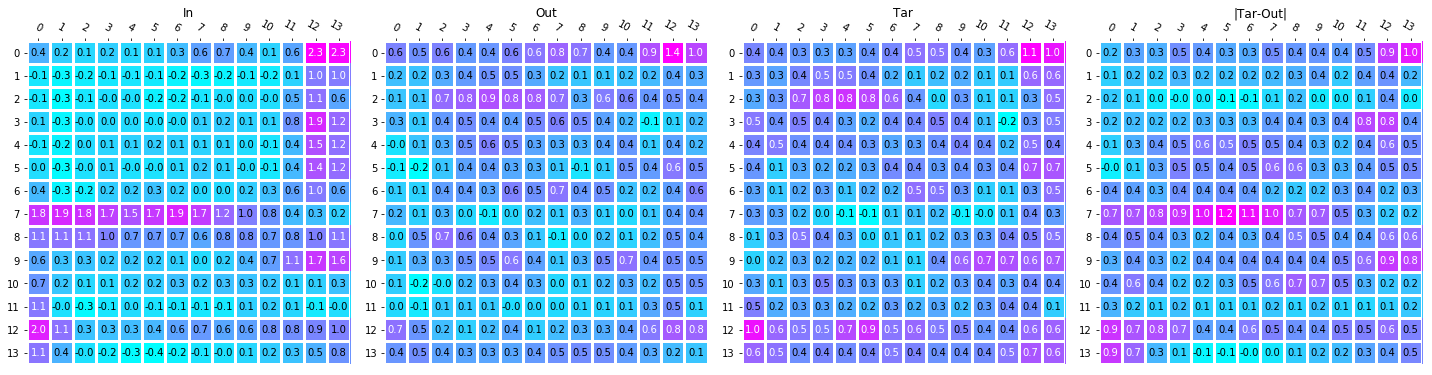

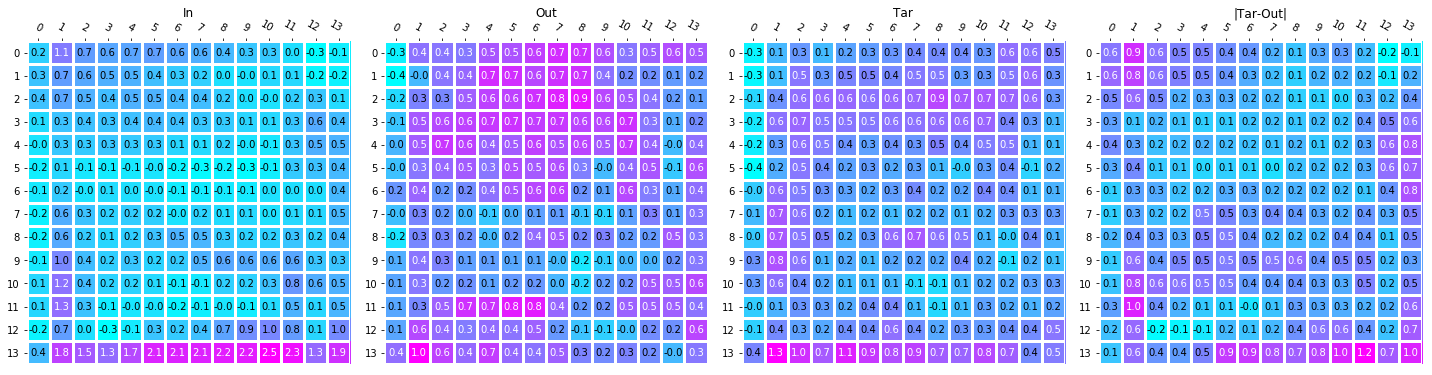

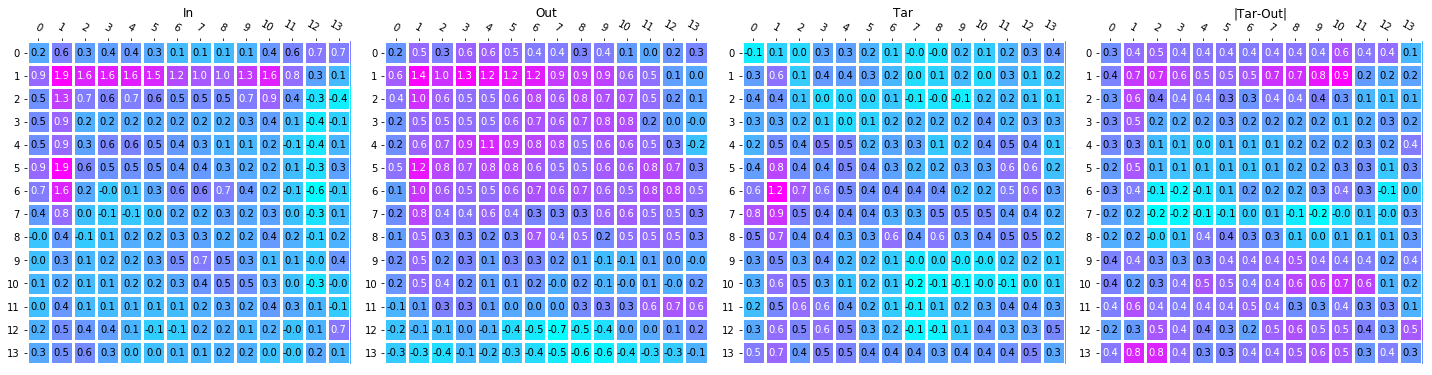

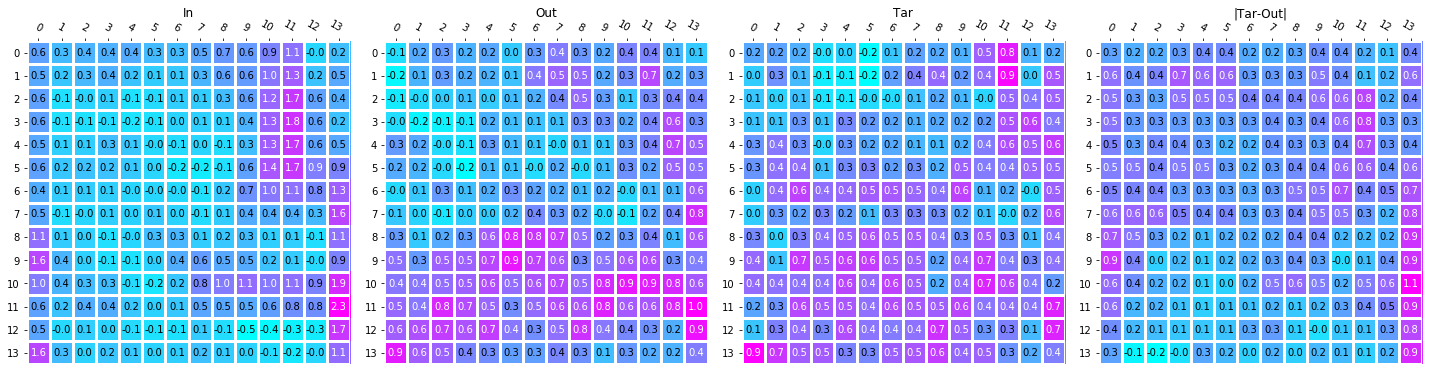

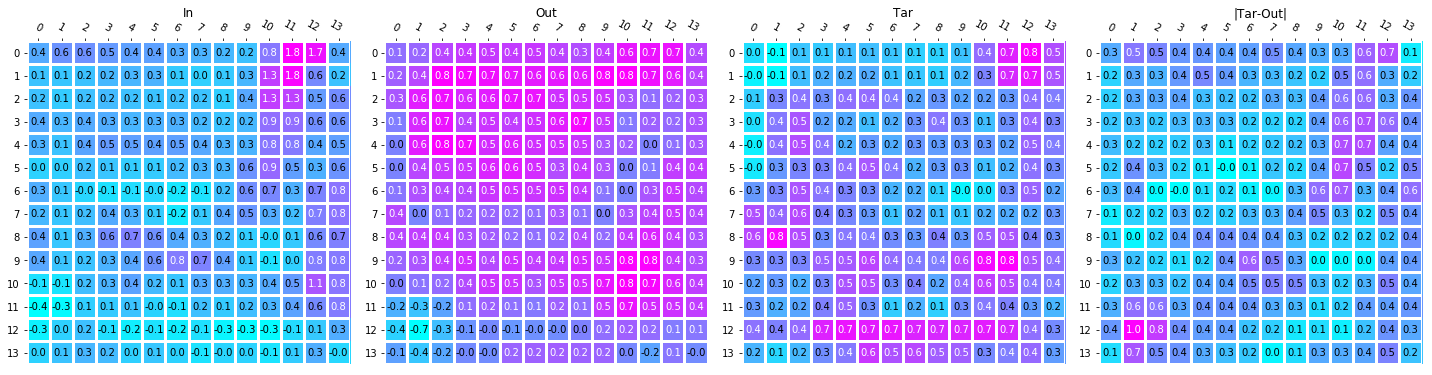

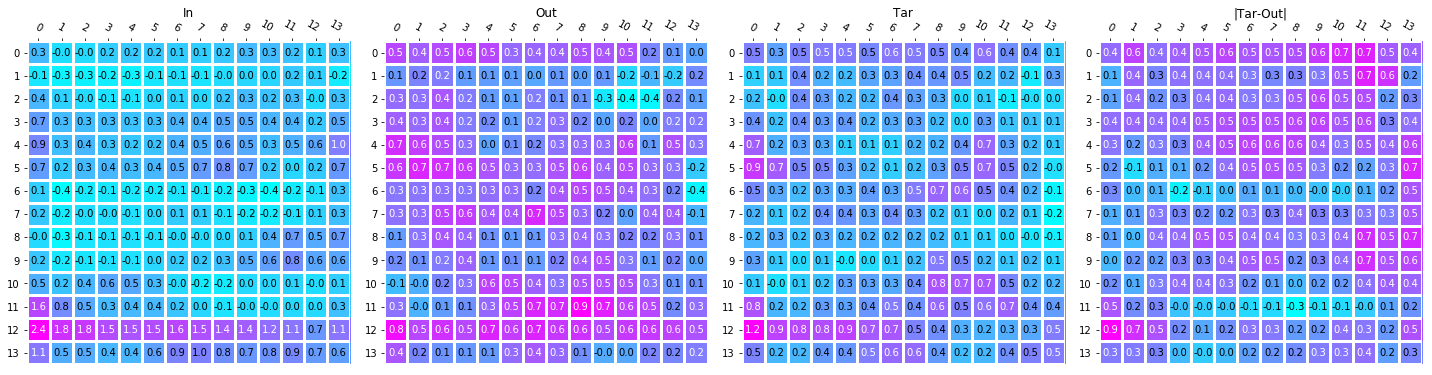

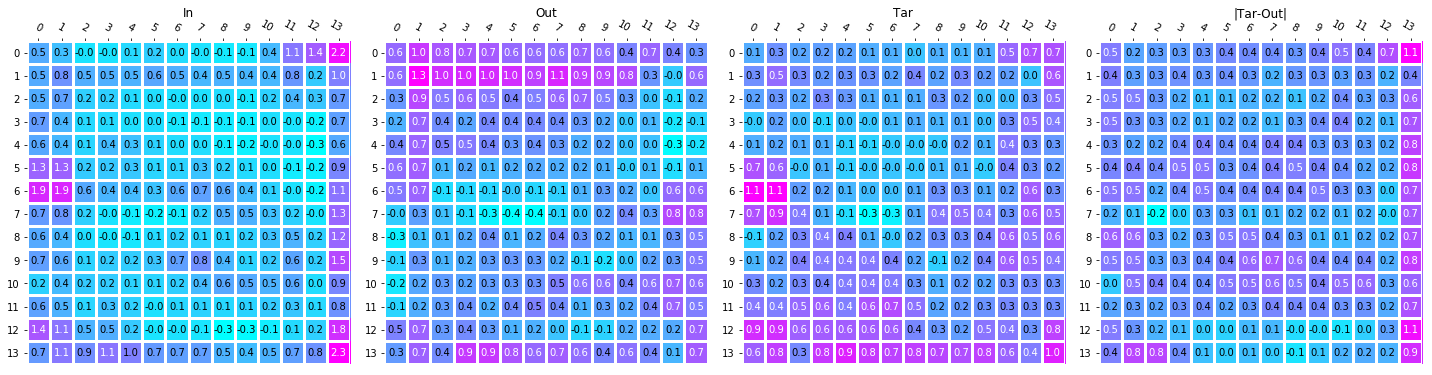

In [25]:
t_list = [3,7,10,34,167,432,500]
for t in t_list:
    lab = range(14)
    fig1, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,20))
    
    im0, cbar0 = heatmap(output[t],lab,lab, ax=ax0,
                       cmap="cool", cbarlabel="",show_cbar=False)
    texts1 = annotate_heatmap(im0, valfmt="{x:.1f}")
    ax0.set_title('In', pad=24)
    
    im1, cbar1 = heatmap(output_n[0][t],lab,lab, ax=ax1,
                       cmap="cool", cbarlabel="", show_cbar=False)
    texts1 = annotate_heatmap(im1, valfmt="{x:.1f}")
    ax1.set_title('Y0', pad=24)

    im2, cbar2 = heatmap(output_n[1][t],lab,lab, ax=ax2,
                       cmap="cool", cbarlabel="", show_cbar=False)
    texts2 = annotate_heatmap(im2, valfmt="{x:.1f}")
    ax2.set_title('Y1', pad=24)

    # fig2, ax3 = plt.subplots(1,1,figsize=(5,5))
    im3, cbar3 = heatmap(output_n[2][t],lab,lab, ax=ax3,
                       cmap="cool", cbarlabel="", show_cbar=False)
    texts3 = annotate_heatmap(im3, valfmt="{x:.1f}")
    ax3.set_title('Y2'',pad=24)


    fig1.tight_layout()
plt.show()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


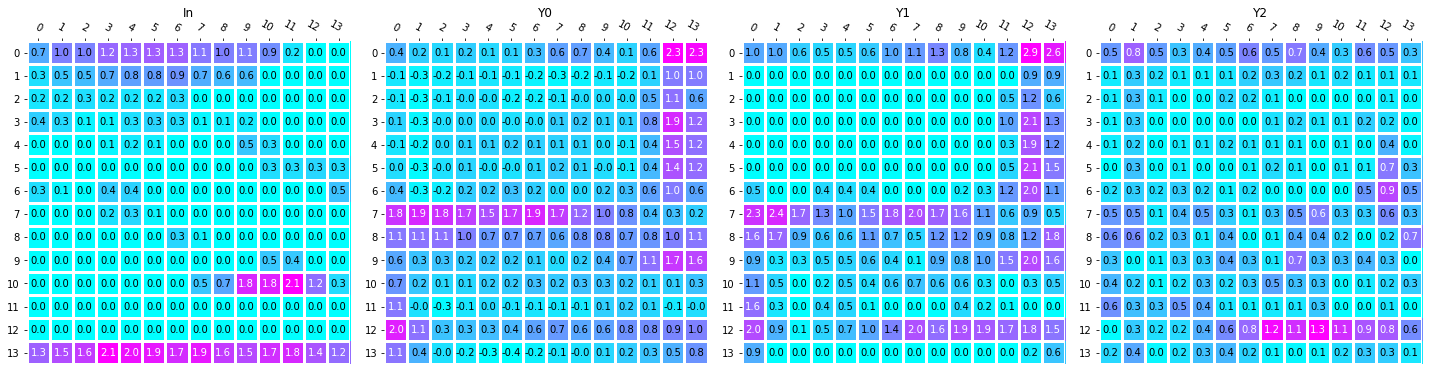

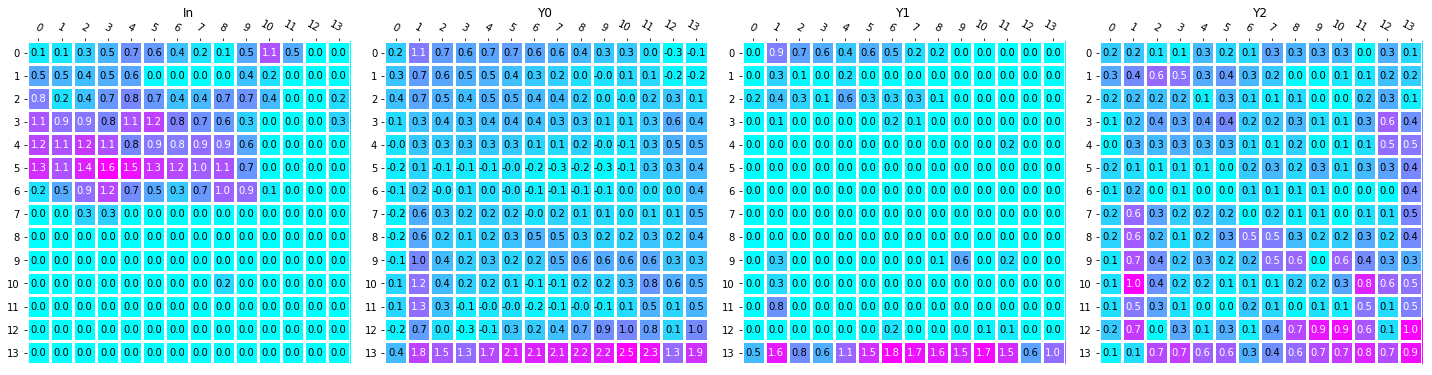

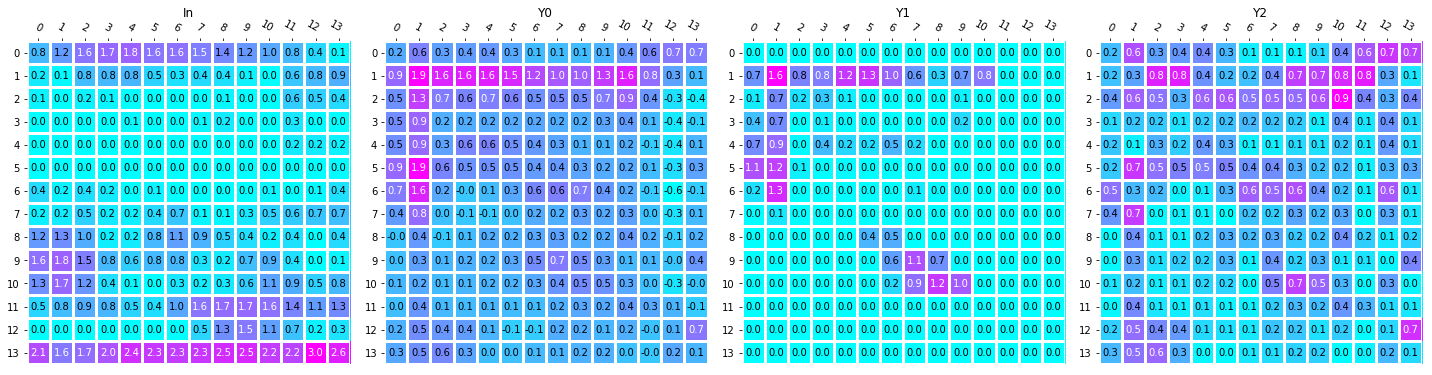

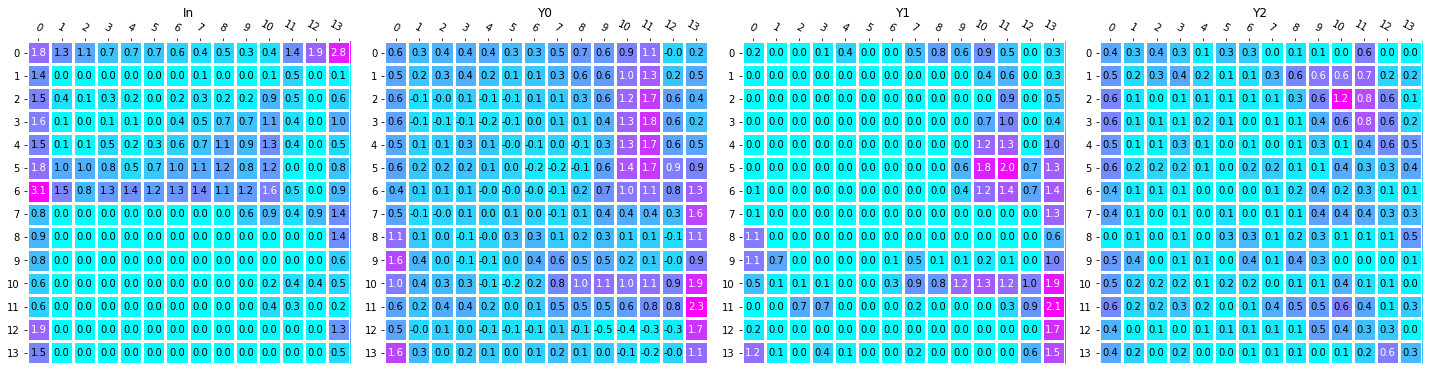

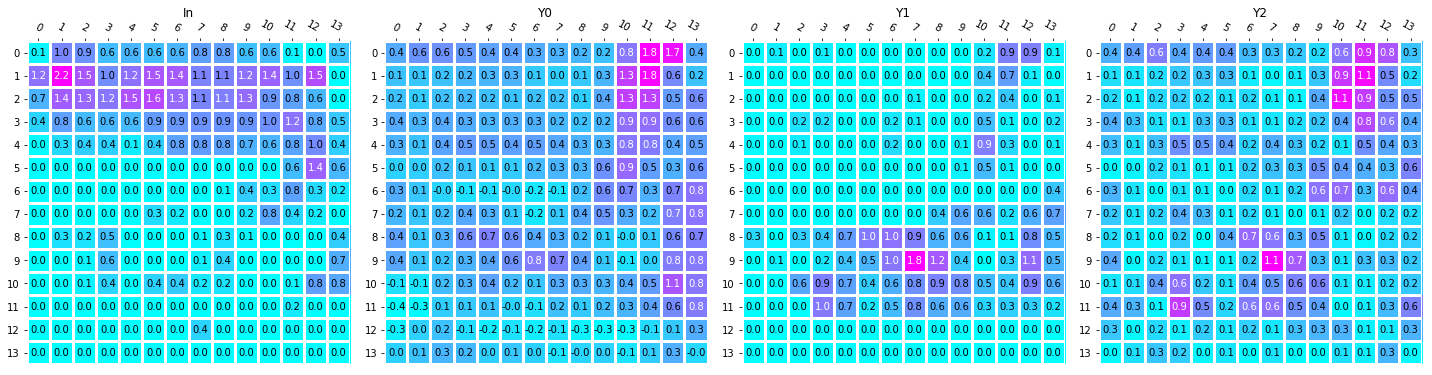

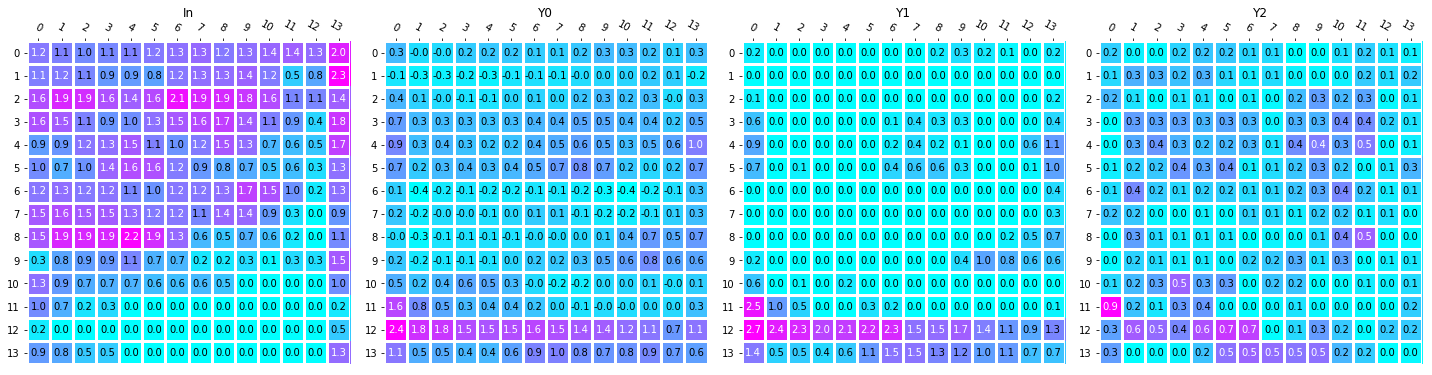

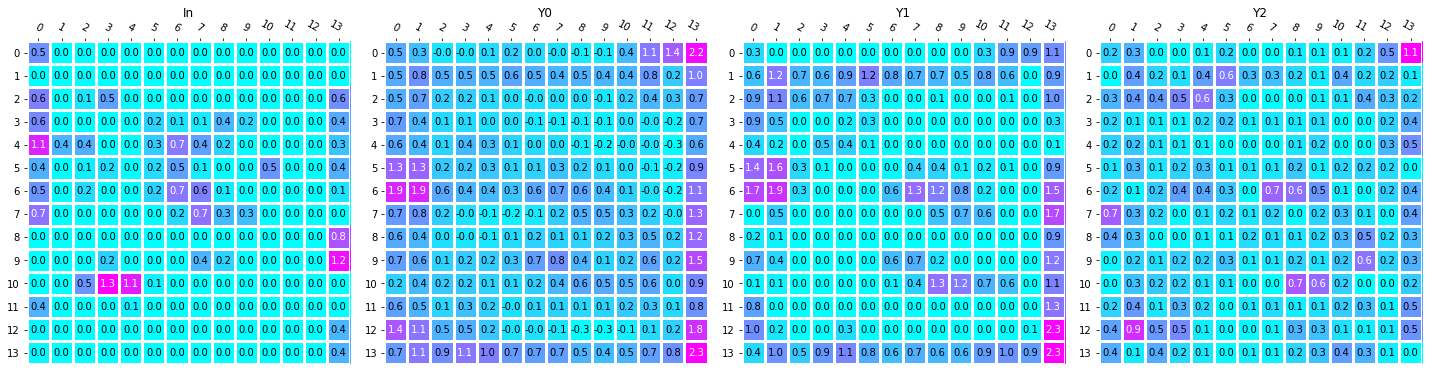